# 目的
- エンゼルの出現確率を購入者毎に予測する
- 独立に予測するのと、階層モデルで予測するのを試す

In [1]:
import os, sys
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

import ChocoUtils as cu

In [2]:
sns.set()

# データの取得

In [3]:
data = cu.get_data(db_file='../../data/choco-ball.db', filter_str="campaign is not 1 and taste is not 10")
data = data.drop(columns=['shop', 'factory'])

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE campaign is not 1 and taste is not 10;
Shape of MeasurementData(record_num, n_columns) : (290, 14)


In [4]:
# 銀のエンゼルのフラグデータ
data['silver'] = [1 if a == 1 else 0 for a in data['angel'].values]
# 金のエンゼル
data['gold'] = [1 if a == 2 else 0 for a in data['angel'].values]

# 購入者の調整
data['buyer'] = ['ピシャイ' if a in 'ピシャイ/佐藤' else a for a in data['buyer'].values]


In [5]:
data.head()

,measure_date,best_before,prd_number,weight,box_weight,ball_number,angel,campaign,taste,buyer,net_weight,mean_weight,silver,gold
0,2017-12-04,2018-02-01,BA6,34.513,4.710,16,0,2,0,根本,29.803,1.862688,0,0
1,2017-12-04,2018-02-01,AA6,33.644,4.731,16,0,2,0,根本,28.913,1.807062,0,0
2,2017-12-10,2018-09-01,CA9,31.103,4.776,15,0,2,1,時田,26.327,1.755133,0,0
3,2017-12-10,2018-09-01,CA9,31.477,4.767,15,0,2,1,時田,26.710,1.780667,0,0
4,2017-12-10,2018-09-01,CA9,31.615,4.777,15,0,2,1,時田,26.838,1.789200,0,0


In [6]:
# 購入者を限定する
data = data.query('buyer in ["ピシャイ", "西田", "時田"]')

grp = data.groupby(['buyer'])
print(grp.count()[['net_weight']])

       net_weight
buyer            
ピシャイ           80
時田            142
西田             59


# エンゼル出現確率の推定

In [7]:
name_dict = {'ピシャイ':'pichai', '時田':'tokita', '西田':'nishida'}

In [8]:
buyer = data['buyer'].values
buyer_idx = pd.Categorical(data['buyer']).codes
buyer_cat = pd.Categorical(data['buyer']).categories
data['buyer_idx'] = buyer_idx
print(buyer_cat)
print(set(buyer_idx))

Index(['ピシャイ', '時田', '西田'], dtype='object')
{0, 1, 2}


In [9]:
total_counts = data.groupby(['buyer_idx']).count()['silver'].values
angel_counts = data.query('silver > 0').groupby(['buyer_idx']).count()['silver'].values

print('total_count : {}'.format(total_counts))
print('angel_count : {}'.format(angel_counts))


total_count : [ 80 142  59]
angel_count : [5 6 2]


max_theta : 0.05050505050505051


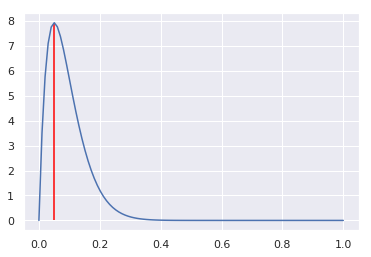

In [10]:
# 事前分布の形確認
(a, b) = (2.0, 20.0)

x = np.linspace(0, 1, 100)
y = stats.beta(a, b).pdf(x)
plt.plot(x, y)
plt.vlines(x=x[y.argmax()], ymin=0, ymax=max(y), colors='red')
print('max_theta : {}'.format(x[y.argmax()]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 5500/5500 [00:03<00:00, 1377.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12bf61400>,
      dtype=object)

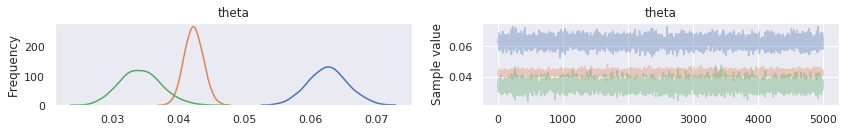

In [11]:
with pm.Model() as comparing_buyer_i:
    #theta = pm.Beta('theta', alpha=1, beta=1, shape=len(set(buyer_idx))) # 一様分布
    theta = pm.Beta('theta', alpha=2, beta=20, shape=len(set(buyer_idx)))
    
    angel = pm.Binomial('angel', n=total_counts[buyer_idx], p=theta[buyer_idx], observed=angel_counts[buyer_idx])
    
    trace = pm.sample(5000, chains=1)
pm.traceplot(trace)

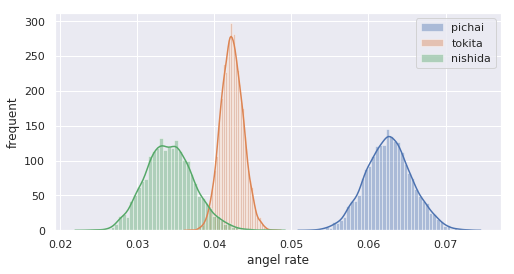

In [12]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

for i in np.arange(len(buyer_cat)):
    sns.distplot(trace['theta'][:,i], label=name_dict[buyer_cat[i]], ax=ax)
ax.legend()
ax.set_xlabel('angel rate')
ax.set_ylabel('frequent')
plt.savefig('buyer_effect.png')